In [3]:
import numpy as np
import cv2
import albumentations as A
import tensorflow as tf
import matplotlib.pyplot as plt

plt.style.use("custom_dark")

2023-09-07 11:30:24.561594: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-07 11:30:25.225270: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lpradier/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-09-07 11:30:25.225422: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lpradier/.local/lib/python3.10/site-packages/cv2/../../l

ESSAI IMG, AUG and PLOT


In [91]:
image = cv2.imread(
    "data/raw/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png"
)
image

array([[[201, 206, 172],
        [201, 207, 174],
        [203, 208, 176],
        ...,
        [ 33,  44,  33],
        [ 33,  44,  33],
        [ 33,  44,  33]],

       [[199, 204, 172],
        [201, 206, 173],
        [203, 207, 174],
        ...,
        [ 35,  45,  34],
        [ 34,  45,  33],
        [ 34,  45,  33]],

       [[199, 204, 173],
        [200, 205, 174],
        [202, 206, 173],
        ...,
        [ 35,  45,  33],
        [ 35,  45,  33],
        [ 34,  45,  33]],

       ...,

       [[ 82,  99,  83],
        [ 81,  98,  82],
        [ 82,  98,  82],
        ...,
        [ 62,  70,  55],
        [ 61,  69,  53],
        [ 60,  68,  53]],

       [[ 82,  99,  83],
        [ 81,  98,  82],
        [ 82,  98,  82],
        ...,
        [ 64,  72,  56],
        [ 62,  71,  55],
        [ 60,  69,  53]],

       [[ 82,  99,  83],
        [ 81,  98,  82],
        [ 82,  98,  82],
        ...,
        [ 64,  71,  54],
        [ 64,  71,  55],
        [ 63,  70,  55]]

In [10]:
light = A.Compose(
    [
        A.HorizontalFlip(p=1),
        A.RandomSizedCrop((800 - 100, 800 + 100), 600, 600),
        A.GaussNoise(var_limit=(100, 150), p=1),
    ]
)

In [15]:
x = light(image=image)


Text(0.5, 1.0, 'Aug_Img')

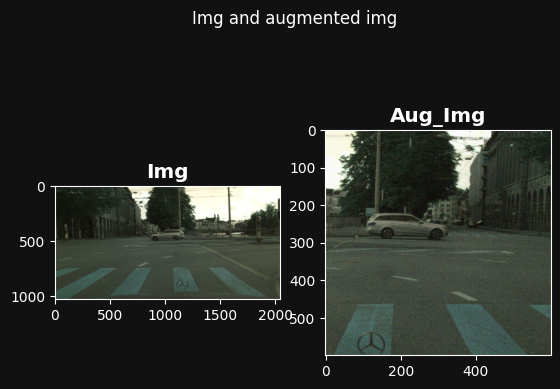

In [25]:
fig, ax = plt.subplots(1, 2)
fig.suptitle("Img and augmented img")
ax[0].imshow(image / 255)
ax[1].imshow(x["image"] / 255)
ax[0].set_title("Img")
ax[1].set_title("Aug_Img")


TEST METHOD AUG IMG


Pas de crop > changement de forme de img
pas forcément suggéré ici
Ici suggère : rotation, cgt echelle, bruit


In [31]:
medium = A.Compose(
    [A.HorizontalFlip(p=1), A.ShiftScaleRotate(
        p=1), A.MotionBlur(blur_limit=17, p=1)]
)

strong = A.Compose(
    [
        A.HorizontalFlip(p=1),
        A.RGBShift(p=1),
        A.ShiftScaleRotate(p=1),
        A.Blur(blur_limit=11, p=1),
        A.RandomBrightness(p=1),
        A.CLAHE(p=1),
    ]
)

/home/lpradier/.local/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Text(0.5, 1.0, 'Aug_Img')

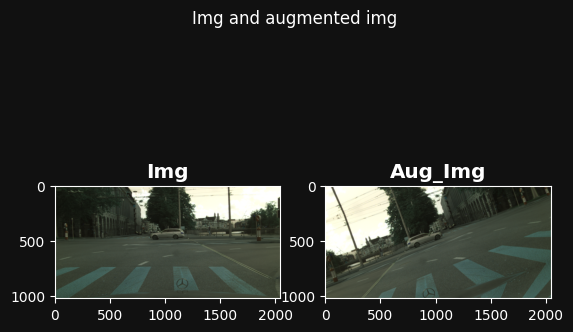

In [32]:
x = medium(image=image)
fig, ax = plt.subplots(1, 2)
fig.suptitle("Img and augmented img")
ax[0].imshow(image / 255)
ax[1].imshow(x["image"] / 255)
ax[0].set_title("Img")
ax[1].set_title("Aug_Img")

Text(0.5, 1.0, 'Aug_Img')

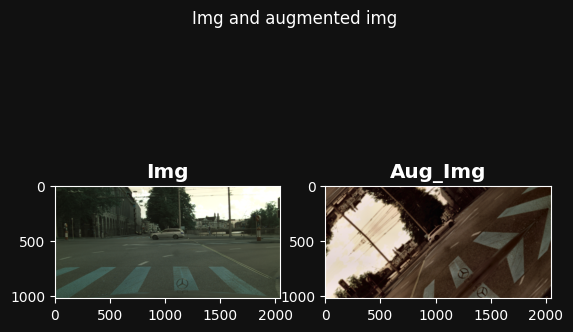

In [33]:
x = strong(image=image)
fig, ax = plt.subplots(1, 2)
fig.suptitle("Img and augmented img")
ax[0].imshow(image / 255)
ax[1].imshow(x["image"] / 255)
ax[0].set_title("Img")
ax[1].set_title("Aug_Img")


Text(0.5, 1.0, 'Aug_Img')

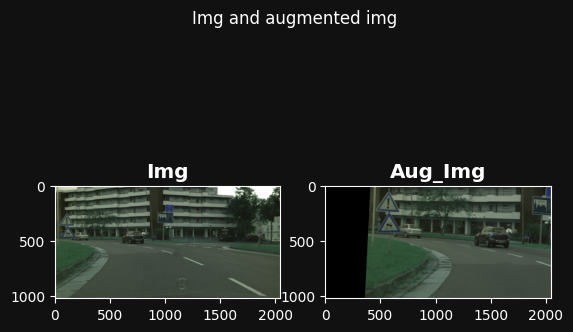

In [95]:
rot = A.Compose(
    [A.Affine(scale=(0.5, 2), translate_percent=(0, 0.5), rotate=(-45, 45), p=1)]
)
x = rot(image=image)
fig, ax = plt.subplots(1, 2)
fig.suptitle("Img and augmented img")
ax[0].imshow(image / 255)
ax[1].imshow(x["image"] / 255)
ax[0].set_title("Img")
ax[1].set_title("Aug_Img")


FCT FILTRAGE


**HEURISTIQUE HOLDOUT**


In [12]:
from itertools import combinations, chain
import os
import random
import shutil


def holdout(image_dir, mask_dir):
    random.seed(42)
    #!1.Comptage des éléments
    city_list = os.listdir(image_dir)
    city_count = []
    for i in city_list:
        temp = len(os.listdir(os.path.join(image_dir, i)))
        city_count.append(temp)
    # FOR TEST ~ 1/6 TRAIN beg
    min_thr = 1 / 10 * sum(city_count)
    max_thr = 1 / 6 * sum(city_count)
    #!2.Sélection des combinaisons de villes qui respectent diverses cdt
    # Build dict
    citytocount = {key: value for key, value in zip(city_list, city_count)}
    result = []
    # Parse combinations with more than 2 cities
    # 3 cities in VALID
    allCombinations = chain(
        *(combinations(city_list, i) for i in range(3, len(city_list) + 1))
    )
    for c in allCombinations:
        # Get count for this combination
        countForThisCombination = sum((citytocount[name] for name in c))
        # Test for min/max
        if countForThisCombination > min_thr and countForThisCombination < max_thr:
            result += [c]
    #!3. Sélection aléatoire de combinaisons parmis les précédentes
    city_test = random.choice(result)
    #!4. Create new test directory
    os.mkdir(image_dir + "/new_test/")
    os.mkdir(mask_dir + "/new_test/")
    #!5. redirect selected train files to test file
    for ville in city_test:
        for dir in [image_dir, mask_dir]:
            source = dir + "/train/" + str(ville)
            destination = dir + "/new_test/" + str(ville)
            shutil.move(source, destination)
    return city_test


In [13]:
image_dir = "data/raw/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit"
mask_dir = "data/raw/P8_Cityscapes_gtFine_trainvaltest/gtFine"

holdout(image_dir, mask_dir)


('tubingen', 'zurich', 'erfurt', 'jena')

**ESSAI CHARGEMENT MASK**


In [4]:
import cv2

# pas besoin de passer la conversion du filtre en gris pour la représentation et le bornage, juste lui passer bien un masque gris de base
img = cv2.imread(
    "data/raw/P8_Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png",
    cv2.IMREAD_COLOR,
)

In [84]:
img

array([[[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       ...,

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]]], dtype=uint8)

In [48]:
dist = [np.min(img), np.max(img)]
dist

[0, 33]

Valeur de luminance cohérente avec les définitions des labels qui nous intéressent : _cats_ (bornées à 33)


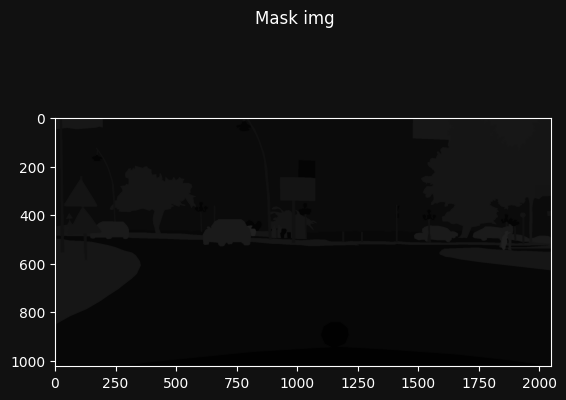

In [5]:
fig, ax = plt.subplots(1, 1)
fig.suptitle("Mask img")
ax.imshow(img)


**Exploration des backbones**


In [ ]:
#
#!penser à récupérer les data
import matplotlib.pyplot
import pandas as pd

plt.style.use("custom_dark")

data = pd.read_csv("/home/lea/Téléchargements/Modèles keras - Feuille 1 (1).csv")
groups = data.groupby("Family")
for name, group in groups:
    plt.plot(
        group["Time (ms) per inference step (GPU)"],
        group["Top-1 Accuracy"],
        marker="o",
        linestyle="",
        markersize=12,
        label=name,
    )
plt.ylabel("Top 1 accuracy")
plt.xlabel("Time(ms)/step (GPU)")
plt.title("Top accuracy~time/step")
plt.legend()

In [ ]:
import matplotlib.pyplot
import pandas as pd

plt.style.use("custom_dark")

data = pd.read_csv("/home/lea/Téléchargements/Modèles keras - Feuille 1 (1).csv")
groups = data.groupby("Family")
for name, group in groups:
    plt.plot(
        group["Time (ms) per inference step (GPU)"],
        group["Top-5 Accuracy"],
        marker="o",
        linestyle="",
        markersize=12,
        label=name,
    )
plt.ylabel("Top 5 accuracy")
plt.xlabel("Time(ms)/step (GPU)")
plt.title("Top 5 accuracy~time/step")
plt.legend()

In [ ]:
import matplotlib.pyplot
import pandas as pd

plt.style.use("custom_dark")

data = pd.read_csv("/home/lea/Téléchargements/Modèles keras - Feuille 1 (1).csv")
groups = data.groupby("Family")
for name, group in groups:
    plt.plot(
        group["Parameters"],
        group["Top-5 Accuracy"],
        marker="o",
        linestyle="",
        markersize=12,
        label=name,
    )
plt.xlabel("Parameters(M)")
plt.ylabel("Top 5 accuracy")
plt.title("Top 5 accuracy~parameters")
plt.legend()

**Étude des classes de segmentation**


In [7]:
from pathlib import Path
import cv2


In [47]:
cats = {
    "void": [0, 1, 2, 3, 4, 5, 6],
    "flat": [7, 8, 9, 10],
    "construction": [11, 12, 13, 14, 15, 16],
    "object": [17, 18, 19, 20],
    "nature": [21, 22],
    "sky": [23],
    "human": [24, 25],
    "vehicle": [26, 27, 28, 29, 30, 31, 32, 33, -1],
}
mask_list = [
    str(f)
    for f in Path("data/raw/P8_Cityscapes_gtFine_trainvaltest/gtFine/train").rglob(
        "*labelIds.png"
    )
]


In [48]:
len(mask_list)

2481

In [13]:
count = {
    "void": [],
    "flat": [],
    "construction": [],
    "object": [],
    "nature": [],
    "sky": [],
    "human": [],
    "vehicle": [],
}

Distribution par image


In [70]:
count = {
    "void": 0,
    "flat": 0,
    "construction": 0,
    "object": 0,
    "nature": 0,
    "sky": 0,
    "human": 0,
    "vehicle": 0,
}


In [71]:
for m in mask_list:
    img = cv2.imread(m, cv2.IMREAD_COLOR)
    for c in cats:
        if np.any(np.isin(img, cats[c])) == True:
            count[c] += 1
count


{'void': 2481,
 'flat': 2463,
 'construction': 2474,
 'object': 2467,
 'nature': 2419,
 'sky': 2242,
 'human': 2092,
 'vehicle': 2450}

In [77]:
import pandas as pd

# prop img occupée par chacune de nos cat
data = [100 * (i / len(mask_list)) for i in count.values()]


In [83]:
data


[100.0,
 99.2744860943168,
 99.71785570334542,
 99.43571140669086,
 97.50100765820234,
 90.36678758565094,
 84.32083837162435,
 98.75050382910116]

([<matplotlib.patches.Wedge at 0x7f9d82cc3910>,
 [Text(1.0095617298730766, 0.4367895529607836, 'void'),
  Text(0.3759008620524597, 1.0337787683582103, 'flat'),
  Text(-0.4920844579586066, 0.9837951444460298, 'construction'),
  Text(-1.052870545074135, 0.31853353876051166, 'object'),
  Text(-0.9598164137286563, -0.5373569129889937, 'nature'),
  Text(-0.31801363026416707, -1.0530276971505574, 'sky'),
  Text(0.4485566581601375, -1.0043888312900586, 'human'),
  Text(1.0117771023291888, -0.43163305619744924, 'vehicle')])

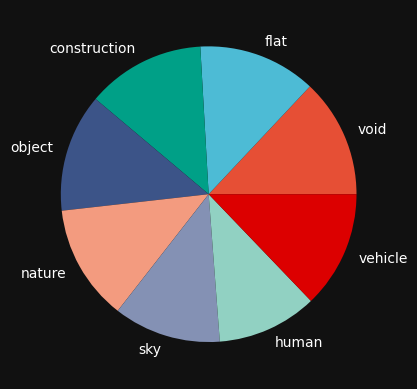

In [82]:
col = [
    "#E64F35",
    "#4DBBD5",
    "#00A087",
    "#3C5488",
    "#F39B7F",
    "#8491B4",
    "#91D1C2",
    "#DC0000",
    "#7E6148",
    "#B09C85",
]
fig, ax = plt.subplots()
ax.pie(data, colors=col, labels=count.keys())


Distribution par px


In [14]:
for m in mask_list:
    img = cv2.imread(m, cv2.IMREAD_COLOR)
    for c in cats:
        n_px = np.count_nonzero(np.isin(img, cats[c]))
        count[c].append(n_px)
count

{'void': [535491,
  542550,
  485451,
  727260,
  373698,
  564195,
  547812,
  703641,
  477726,
  499695,
  411165,
  472569,
  629547,
  912876,
  398664,
  395583,
  387381,
  708348,
  583584,
  344292,
  516471,
  384444,
  571377,
  700347,
  439770,
  471465,
  541281,
  567861,
  544161,
  564015,
  389574,
  604374,
  505089,
  568167,
  704847,
  533214,
  575688,
  445353,
  706329,
  577854,
  367335,
  441264,
  655935,
  1092408,
  466980,
  596241,
  743994,
  367818,
  658806,
  573999,
  617478,
  418584,
  864930,
  574206,
  1043187,
  490416,
  515370,
  481155,
  354198,
  471108,
  491466,
  434655,
  582342,
  668178,
  748752,
  348141,
  675198,
  346353,
  400209,
  361974,
  474414,
  767031,
  594987,
  451974,
  452430,
  457812,
  378237,
  776967,
  461205,
  540912,
  481470,
  475986,
  443910,
  558822,
  449604,
  634686,
  470481,
  480210,
  370098,
  953589,
  532854,
  510894,
  632481,
  517545,
  398436,
  655971,
  653241,
  395109,
  380283,


In [27]:
import pandas as pd

data = pd.DataFrame(count)
# data.sum(axis=1)  # taille d'une img
100 * (data / 6291456)  # prop img occupée par chacune de nos cat


,void,flat,construction,object,nature,sky,human,vehicle
0,8.511400,38.838768,16.389894,1.981735,23.710632,0.478554,0.239182,9.849834
1,8.623600,40.855742,22.313023,2.976561,7.867336,3.802156,0.119305,13.442278
2,7.716036,40.984583,11.141014,3.537750,26.826191,1.868916,0.614643,7.310867
3,11.559486,35.042763,25.494671,3.820705,5.947161,5.587053,9.129620,3.418541
4,5.939770,35.458755,0.627565,1.662397,35.389233,6.029320,0.000000,14.892960
...,...,...,...,...,...,...,...,...
2476,12.065411,46.463633,11.659575,0.409746,23.963308,4.962063,0.176668,0.299597
2477,14.532757,36.515188,13.688135,2.355909,21.435738,1.398230,0.648642,9.425402
2478,11.876917,44.221878,25.053644,0.767565,9.112549,7.580900,0.305128,1.081419
2479,12.423944,37.446404,21.881247,0.940657,8.831358,5.419683,0.000000,13.056707


([<matplotlib.patches.Wedge at 0x7f9d8360fbb0>,
 [Text(1.0397810302641803, 0.35896435631237783, 'void'),
  Text(-0.3406536468146887, 1.0459230817377794, 'flat'),
  Text(-0.87483009593522, -0.6668375388698315, 'construction'),
  Text(-0.1920869532932796, -1.0830986115652192, 'object'),
  Text(0.36475813166684895, -1.037762740409825, 'nature'),
  Text(0.8667115607355702, -0.6773559407632831, 'sky'),
  Text(0.958871955970737, -0.5390404178286199, 'human'),
  Text(1.0692044439231527, -0.25846055229953757, 'vehicle')])

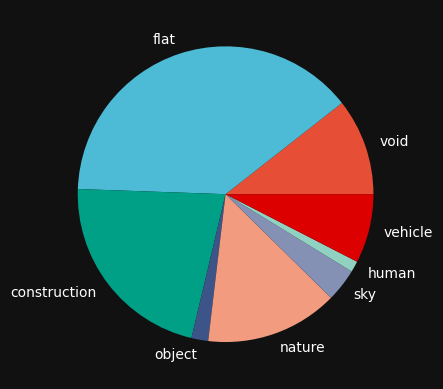

In [30]:
col = [
    "#E64F35",
    "#4DBBD5",
    "#00A087",
    "#3C5488",
    "#F39B7F",
    "#8491B4",
    "#91D1C2",
    "#DC0000",
    "#7E6148",
    "#B09C85",
]
fig, ax = plt.subplots()
ax.pie(data.sum(), colors=col, labels=data.columns.tolist())


Proportion occupée par les plus grosses cats


In [40]:
100 * (data.sum()[["void", "flat", "construction", "nature"]].sum() / data.sum().sum())

85.8036520595466

Prop moyenne occ par chaque cat dans les images


In [41]:
data.sum() / data.sum().sum()

void            0.105812
flat            0.388599
construction    0.218491
object          0.018325
nature          0.145134
sky             0.036120
human           0.012022
vehicle         0.075497
dtype: float64

> recup pour pondérer la loss


TEST MOSAIC


In [1]:
from pathlib import Path

import sys

sys.path.append("src/modeling/")

In [2]:
from data_generator import DataGenerator as dg

x = [
    str(f)
    for f in Path(
        "data/raw/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train"
    ).rglob("*.png")
]
y = [
    str(f)
    for f in Path("data/raw/P8_Cityscapes_gtFine_trainvaltest/gtFine/train").rglob(
        "*labelIds.png"
    )
]
x.sort()
y.sort()
training_generator = dg(
    img_list=x,
    mask_list=y,
    batch_size=16,
    shuffle=True,
    aug_list=["hflip", "rotateb", "gnoise"],
    mosaic=True,
    img_height=1024,
    img_width=2048,
)


2023-09-13 13:41:46.456317: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-13 13:41:46.900244: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-13 13:41:46.900281: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-09-13 13:41:46.900284: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
x, y = training_generator.__getitem__(0)


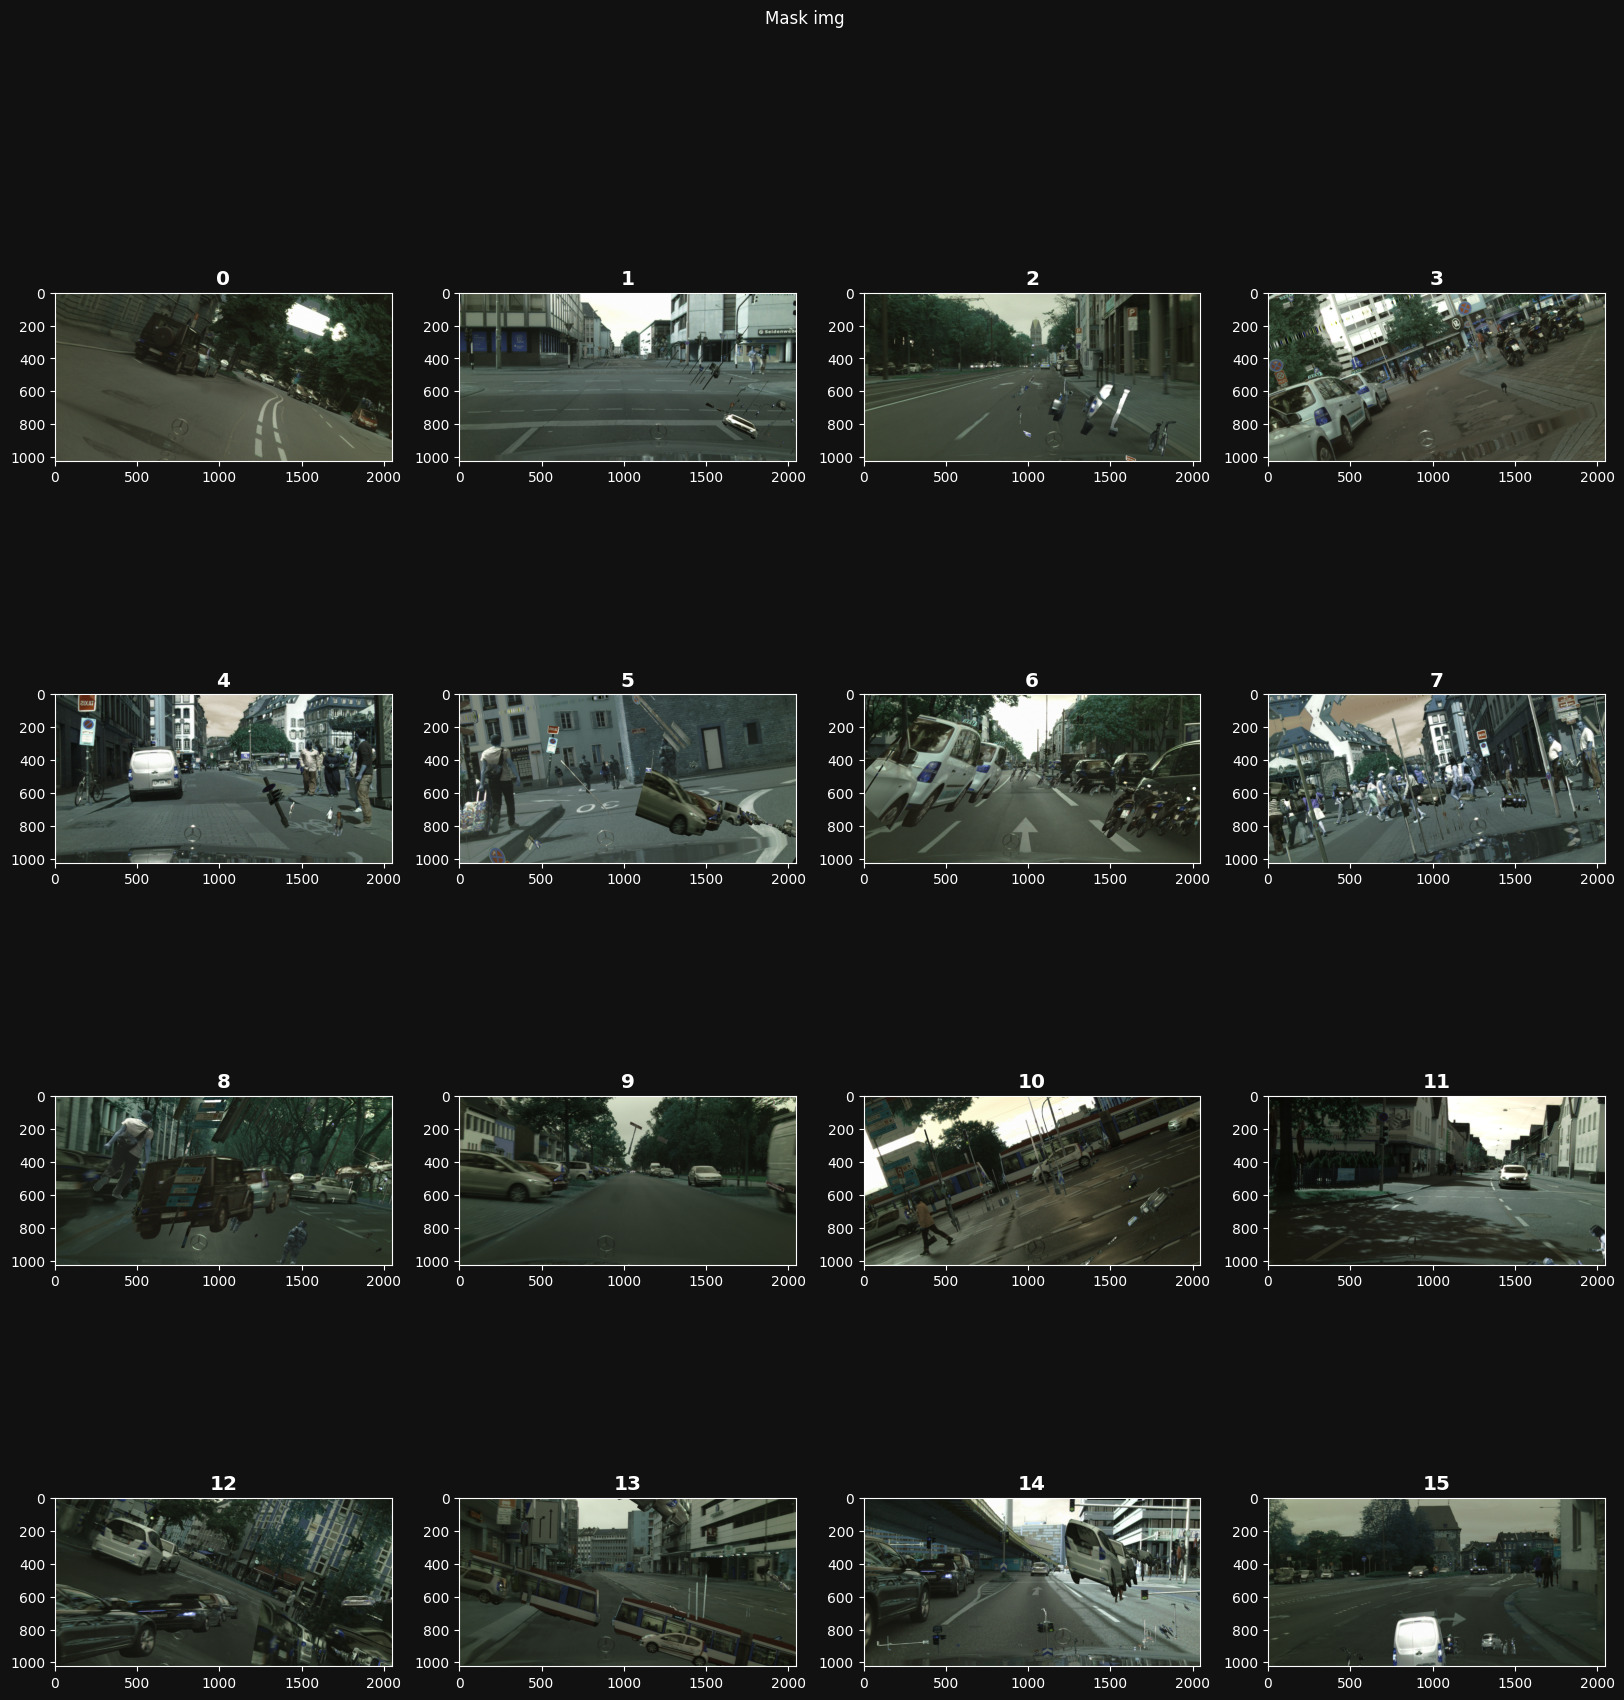

In [4]:
import matplotlib.pyplot as plt

plt.style.use("custom_dark")

fig, ax = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle("Mask img")
c = 0
for i in range(4):
    for j in range(4):
        ax[i, j].imshow(x[c])
        ax[i, j].set_title(str(c))
        c += 1

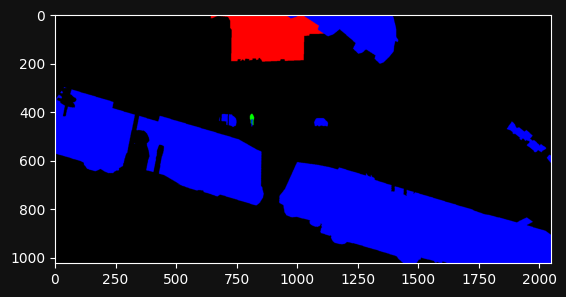

In [5]:
import numpy as np

plt.imshow(y[13][:, :, 5:])


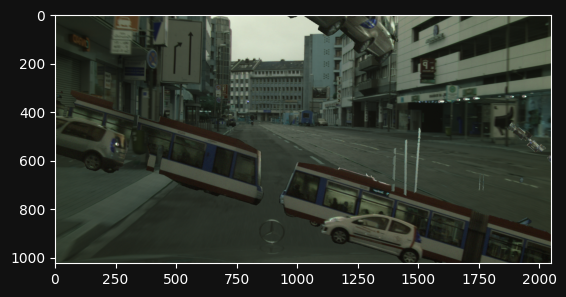

In [6]:
plt.imshow(x[13])


**Comparaison des modèles**


In [12]:
import pandas as pd
from labellines import labelLines, labelLine
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axisartist.parasite_axes import HostAxes

In [19]:
runs = pd.read_csv("/home/lpradier/Téléchargements/runs (8).csv")

In [ ]:
# runs = runs.loc[
#     ~runs["Name"].isin(
#         ["simple_cv1", "simple_cv2", "simple_cv3", "simple_cv4", "simple_cv"]
#     ),
#     :,
# ]

# runs["Name"].str.contains("advanced").sum()

# runs = runs[
#     runs["Name"].str.contains("simple")
#     | runs["Name"].str.contains("advanced")
#     | runs["Name"].str.contains("bert")
# ]
# runs = runs[~runs["Name"].str.contains("_v")]


Fig UNET mobilenet resnet effnet avec ou sans aug


In [20]:
runs["Name"] = pd.Categorical(
    runs["Name"],
    categories=[
        "unetmini",
        "unet_mobilenet",
        "unet_mobilenet_aug",
        "pretrained_unet_resnet50_aug",
        "pretrained_unet_effnet_aug",
    ],
)
runs.sort_values("Name", inplace=True)
runs.dropna(subset="Name", inplace=True)

/home/lpradier/.local/lib/python3.10/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child0), but could not find a label for it.
  warnings.warn(


[]

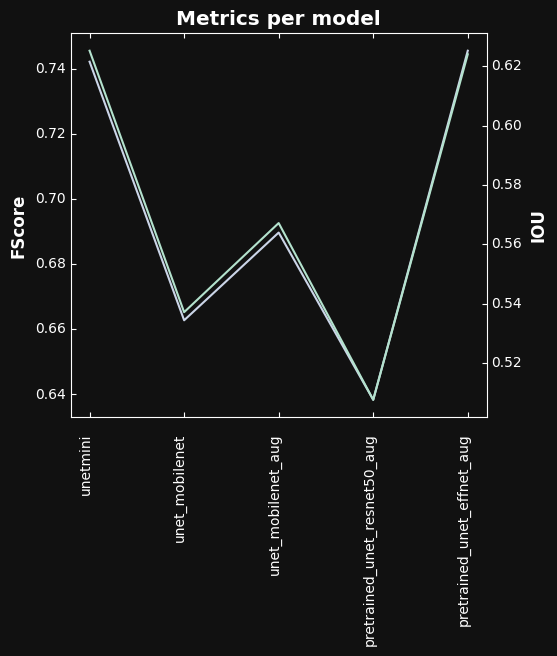

In [21]:
plt.style.use("custom_dark")

fig = plt.figure()

host = fig.add_axes([0.15, 0.1, 0.65, 0.8], axes_class=HostAxes)
par1 = host.get_aux_axes(viewlim_mode=None, sharex=host)
host.axis["right"].set_visible(False)

par1.axis["right"].set_visible(True)
par1.axis["right"].major_ticklabels.set_visible(True)
par1.axis["right"].label.set_visible(True)

host.plot(runs["Name"], runs["FScore"])
par1.plot(runs["Name"], runs["IOUScore"])

host.set(ylabel="FScore")
par1.set(ylabel="IOU")

plt.setp(host.axis["bottom"].major_ticklabels, rotation=90, ha="right")
host.set_title("Metrics per model")
labelLines(host.get_lines())
labelLines(par1.get_lines())

Fig Fnet Rdcrop ou non


Fig Unet pspnet FPN


Fig mosaic/oversampling


In [ ]:
plt.style.use("custom_dark")

fig = plt.figure()

host = fig.add_axes([0.15, 0.1, 0.65, 0.8], axes_class=HostAxes)
par1 = host.get_aux_axes(viewlim_mode=None, sharex=host)
host.axis["right"].set_visible(False)

par1.axis["right"].set_visible(True)
par1.axis["right"].major_ticklabels.set_visible(True)
par1.axis["right"].label.set_visible(True)

host.plot(runs["Name"], runs["PR_AUC"], label="PR_AUC")
host.plot(runs["Name"], runs["Accuracy"], label="Acc")
par1.plot(runs["Name"], runs["Training_time"], label="Time")

host.set(ylim=(0.5, 1), ylabel="Metrics")
par1.set(ylabel="Training time", yscale="log")

plt.setp(host.axis["bottom"].major_ticklabels, rotation=90, ha="right")
host.set_title("Metrics per model")
labelLines(host.get_lines())
labelLines(par1.get_lines())